In [ ]:

import os, math
import numpy as np
import pandas as pd

F_SPECIES = "species_targets.csv"   # species_id,f_target,v_tol
F_W       = "W_matrix.csv"          # primera col 'species_id'
F_NODES   = "nodes_100.csv"         # node_id,x,y,status,species_id
F_ADJ     = "adjacency.csv"         # se genera si no existe
F_TMAT    = "T_matrix.csv"          # matriz 10x10, filas=origen i, cols=vecino j
F_OUT     = "assignments.csv"

RADIUS_M  = 3.2          # vecindad por radio (m), igual a tu diseño (~3.2)
SPECIES_IDS = [
    "AG_LEC","AG_SAL","AG_SCB","AG_STR",
    "OP_CAN","OP_ENG","OP_ROB","OP_STR",
    "PR_LAE","YU_FIL"
]
SIDX = {s:i for i,s in enumerate(SPECIES_IDS)}
rng  = np.random.default_rng(42)

def load_species_targets(path):
    df = pd.read_csv(path).copy()
    req = {"species_id","f_target","v_tol"}
    if not req.issubset(df.columns):
        raise ValueError(f"[{path}] faltan columnas {sorted(req)}")
    df["species_id"] = df["species_id"].astype(str).str.strip()
    miss = set(SPECIES_IDS) - set(df["species_id"])
    extra= set(df["species_id"]) - set(SPECIES_IDS)
    if miss or extra:
        raise ValueError(f"[{path}] especies desalineadas. Faltan={sorted(miss)} Sobran={sorted(extra)}")
    df = df.set_index("species_id").loc[SPECIES_IDS].reset_index()
    df["f_target"] = pd.to_numeric(df["f_target"], errors="raise")
    df["v_tol"]    = pd.to_numeric(df["v_tol"],    errors="raise")
    s = float(df["f_target"].sum())
    if s <= 0: raise ValueError("f_target debe sumar > 0")
    df["f_target"] /= s
    return df

def load_W_matrix(path):
    W = pd.read_csv(path).copy()
    W.columns = [c.strip() for c in W.columns]
    if W.columns[0].lower() != "species_id":
        raise ValueError("[W_matrix.csv] primera columna debe ser 'species_id'")
    W["species_id"] = W["species_id"].astype(str).str.strip()
    W = W.set_index("species_id").loc[SPECIES_IDS, SPECIES_IDS].astype(float)
    W = 0.5*(W + W.T); W[W<0] = 0.0
    return W.to_numpy()

def load_T_matrix(path):
    T = pd.read_csv(path, index_col=0)
    T = T.reindex(index=SPECIES_IDS, columns=SPECIES_IDS)
    A = T.to_numpy(dtype=float)
    A = np.nan_to_num(A, nan=0.0, posinf=0.0, neginf=0.0)
    row_sums = A.sum(axis=1, keepdims=True)
    A = np.divide(A, np.where(row_sums==0, 1.0, row_sums))
    eps = 1e-12
    A = np.clip(A, eps, 1.0)
    return A

def build_edges_radius(df_all, radius):
    """Vecindad geométrica por radio; devuelve pares (u,v) con u<v."""
    pts = df_all[["x","y"]].to_numpy(float)
    ids = df_all["node_id"].astype(str).tolist()
    s = radius; r2 = radius*radius
    cell = {}
    for k,(x,y) in enumerate(pts):
        cx, cy = int(math.floor(x/s)), int(math.floor(y/s))
        cell.setdefault((cx,cy), []).append(k)
    neigh = [(dx,dy) for dx in (-1,0,1) for dy in (-1,0,1)]
    edges = set()
    for (cx,cy), idxs in cell.items():
        cand = set()
        for dx,dy in neigh:
            cand.update(cell.get((cx+dx,cy+dy), []))
        for i in idxs:
            xi, yi = pts[i]
            for j in cand:
                if j <= i: continue
                dx, dy = xi-pts[j,0], yi-pts[j,1]
                if dx*dx + dy*dy <= r2:
                    u, v = ids[i], ids[j]
                    if v < u: u,v = v,u
                    edges.add((u,v))
    return sorted(edges)

def evaluate_W_cost(W, nn_u, nn_v, ne_i, ne_jE, assign_idx):
    c = 0.0
    if nn_u.size:
        c += float(np.sum(W[assign_idx[nn_u], assign_idx[nn_v]]))
    if ne_i.size:
        c += float(np.sum(W[assign_idx[ne_i],  ne_jE]))
    return c


In [ ]:

species_df = load_species_targets(F_SPECIES)
W = load_W_matrix(F_W)
T = load_T_matrix(F_TMAT)               # T[i,j] ~ P(vecino=j | centro=i)
logT = np.log(T)

nodes_df = pd.read_csv(F_NODES).copy()
nodes_df["status"]     = nodes_df["status"].astype(str).str.lower().str.strip()
nodes_df["species_id"] = nodes_df["species_id"].fillna("").astype(str).str.strip()
nodes_df["x"] = pd.to_numeric(nodes_df["x"], errors="coerce")
nodes_df["y"] = pd.to_numeric(nodes_df["y"], errors="coerce")

exist_df = nodes_df[nodes_df["status"]=="existing"].copy().reset_index(drop=True)
avail_df = nodes_df[nodes_df["status"]=="available"].copy().reset_index(drop=True)
exist_df["node_id"] = exist_df["node_id"].astype(str)
avail_df["node_id"] = avail_df["node_id"].astype(str)

active_df = pd.concat([exist_df, avail_df], ignore_index=True)
active_df["node_id"] = active_df["node_id"].astype(str)
if os.path.exists(F_ADJ):
    adj_df = pd.read_csv(F_ADJ)
    adj_df = adj_df.rename(columns={adj_df.columns[0]:"u_node_id", adj_df.columns[1]:"v_node_id"})
    adj_df["u_node_id"] = adj_df["u_node_id"].astype(str)
    adj_df["v_node_id"] = adj_df["v_node_id"].astype(str)
else:
    edges = build_edges_radius(active_df, RADIUS_M)
    adj_df = pd.DataFrame(edges, columns=["u_node_id","v_node_id"])
    adj_df.to_csv(F_ADJ, index=False)

set_av = set(avail_df["node_id"])
set_ex = set(exist_df["node_id"])
edges_nn, edges_ne = [], []
for u,v in adj_df[["u_node_id","v_node_id"]].itertuples(index=False, name=None):
    inA_u, inA_v = u in set_av, v in set_av
    inE_u, inE_v = u in set_ex, v in set_ex
    if inA_u and inA_v:
        edges_nn.append((u,v))
    elif inA_u and inE_v:
        edges_ne.append((u,v))
    elif inE_u and inA_v:
        edges_ne.append((v,u))

aidx = {nid:i for i,nid in enumerate(avail_df["node_id"])}
eidx = {nid:i for i,nid in enumerate(exist_df["node_id"])}

if edges_nn:
    nn_u = np.array([aidx[u] for (u,_) in edges_nn], dtype=np.int32)
    nn_v = np.array([aidx[v] for (_,v) in edges_nn], dtype=np.int32)
else:
    nn_u = np.zeros(0, dtype=np.int32); nn_v = np.zeros(0, dtype=np.int32)

exist_species_idx = np.array([SIDX[s] for s in exist_df["species_id"]], dtype=np.int32) if len(exist_df) else np.zeros(0, dtype=np.int32)
if edges_ne:
    ne_i  = np.array([aidx[u] for (u,_) in edges_ne], dtype=np.int32)
    ne_jE = np.array([exist_species_idx[eidx[v]] for (_,v) in edges_ne], dtype=np.int32)
else:
    ne_i  = np.zeros(0, dtype=np.int32); ne_jE = np.zeros(0, dtype=np.int32)

N = len(avail_df)
Ttot = N + len(exist_df)


In [ ]:

P_exist = np.zeros(len(SPECIES_IDS), dtype=int)
if len(exist_df):
    idx = np.array([SIDX[s] for s in exist_df["species_id"]], dtype=int)
    uniq, cnt = np.unique(idx, return_counts=True)
    P_exist[uniq] = cnt

f_vec = species_df["f_target"].to_numpy(float)
v_vec = species_df["v_tol"].to_numpy(float)

low_final = np.maximum(0.0, (f_vec - v_vec) * Ttot)
upp_final = np.minimum(Ttot, (f_vec + v_vec) * Ttot)
L = np.maximum(0, np.ceil (low_final - P_exist)).astype(int)
U = np.maximum(0, np.floor(upp_final - P_exist)).astype(int)

if (L > U).any():
    bad = [(SPECIES_IDS[i], int(L[i]), int(U[i])) for i in np.where(L>U)[0]]
    raise ValueError(f"Infeasible bands per species: {bad}")
if L.sum() > N or N > U.sum():
    raise ValueError(f"Infeasible totals: sum L={int(L.sum())}, N={N}, sum U={int(U.sum())}")

x_target = np.round(f_vec*Ttot - P_exist).astype(int)

def project_counts(N_new, L, U, x_target):
    x = np.clip(x_target, L, U).astype(int)
    for _ in range(2):
        s = int(x.sum())
        if s < N_new:
            deficit = N_new - s
            order = np.argsort(-(U - x))
            for k in order:
                if deficit <= 0: break
                add = int(min(deficit, U[k]-x[k]))
                if add>0: x[k]+=add; deficit-=add
        elif s > N_new:
            excess = s - N_new
            order = np.argsort(-(x - L))
            for k in order:
                if excess <= 0: break
                dec = int(min(excess, x[k]-L[k]))
                if dec>0: x[k]-=dec; excess-=dec
        else:
            break
    if int(x.sum()) != N_new:
        raise ValueError("No fue posible proyectar cuentas a [L,U].")
    return x

x_new = project_counts(N, L, U, x_target)   # cuentas que debemos asignar en 'available'


In [ ]:

adj_nn = [[] for _ in range(N)]
for u,v in zip(nn_u, nn_v):
    adj_nn[u].append(v); adj_nn[v].append(u)

adj_ne = [[] for _ in range(N)]  
for i, eE in zip(ne_i, ne_jE):
    adj_ne[i].append(int(eE))

deg = np.array([len(adj_nn[i]) + len(adj_ne[i]) for i in range(N)])
order = list(np.argsort(-deg))

remaining = {SPECIES_IDS[i]: int(x_new[i]) for i in range(len(SPECIES_IDS))}
assign_idx = -np.ones(N, dtype=np.int32)

def best_species_for_node(i):
    best_e, best_score = None, -1e300
    for e_idx, sid in enumerate(SPECIES_IDS):
        if remaining[sid] <= 0: 
            continue
        s = 0.0
        for t in adj_nn[i]:
            et = assign_idx[t]
            if et != -1:
                s += logT[e_idx, et]
        for eE in adj_ne[i]:
            s += logT[e_idx, eE]
        if s > best_score:
            best_score = s; best_e = e_idx
    return best_e

for i in order:
    e = best_species_for_node(i)
    if e is None:
        e = int(np.argmax([remaining[s] for s in SPECIES_IDS]))
    assign_idx[i] = e
    remaining[SPECIES_IDS[e]] -= 1

counts_new = np.bincount(assign_idx, minlength=len(SPECIES_IDS))
if not np.array_equal(counts_new, x_new):
    raise RuntimeError("Los conteos asignados no coinciden con x_new.")


In [ ]:

assign_species = [SPECIES_IDS[int(k)] for k in assign_idx]

out = avail_df[["node_id","x","y"]].copy()
out["node_id"] = out["node_id"].astype(str)
out["status"] = "available_assigned"
out["species_id"] = assign_species

exist_out = exist_df[["node_id","x","y","status","species_id"]].copy()
exist_out["node_id"] = exist_out["node_id"].astype(str)

final_out = pd.concat([exist_out, out], ignore_index=True)
final_out.to_csv(F_OUT, index=False)
print(f"[OK] Escribí {F_OUT}")


cost_W = evaluate_W_cost(W, nn_u, nn_v, ne_i, ne_jE, assign_idx)
print(f"Costo W (NN+NE) con esta asignación guiada por T: {cost_W:,.3f}")


summary = pd.DataFrame({
    "species_id":  SPECIES_IDS,
    "P_exist":     [int(P_exist[i]) for i in range(len(SPECIES_IDS))],
    "x_new":       [int(x_new[i])   for i in range(len(SPECIES_IDS))],
    "total_final": [int(P_exist[i] + x_new[i]) for i in range(len(SPECIES_IDS))],
    "lower":       [int(math.ceil(low_final[i])) for i in range(len(SPECIES_IDS))],
    "upper":       [int(math.floor(upp_final[i])) for i in range(len(SPECIES_IDS))],
})
summary["feasible_band"] = (summary["total_final"]>=summary["lower"]) & (summary["total_final"]<=summary["upper"])
summary


[OK] Escribí assignments.csv
Costo W (NN+NE) con esta asignación guiada por T: 140.977


,species_id,P_exist,x_new,total_final,lower,upper,feasible_band
0,AG_LEC,1,6,7,6,7,True
1,AG_SAL,2,28,30,29,31,True
2,AG_SCB,0,6,6,6,7,True
3,AG_STR,0,6,6,6,7,True
4,OP_CAN,3,4,7,7,8,True
5,OP_ENG,1,5,6,5,6,True
6,OP_ROB,2,9,11,10,12,True
7,OP_STR,0,10,10,9,11,True
8,PR_LAE,0,13,13,12,14,True
9,YU_FIL,1,3,4,4,4,True


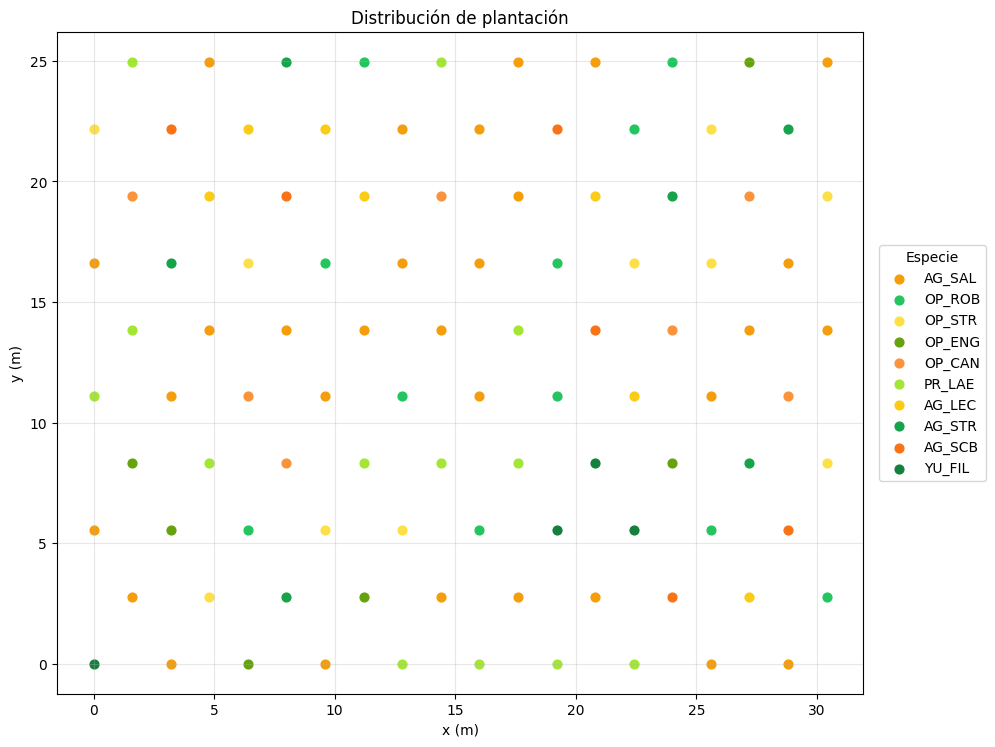

Mapa guardado en: plantacion_mapa.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


PALETTE = {
    "AG_SAL": "#F59E0B",  # Agave salmiana
    "OP_ROB": "#22C55E",  # Opuntia robusta
    "OP_STR": "#FDE047",  # Opuntia streptacantha
    "OP_ENG": "#65A30D",  # Opuntia engelmannii
    "OP_CAN": "#FB923C",  # Opuntia cantabrigiensis
    "PR_LAE": "#A3E635",  # Prosopis laevigata
    "AG_LEC": "#FACC15",  # Agave lechuguilla
    "AG_STR": "#16A34A",  # Agave striata
    "AG_SCB": "#F97316",  # Agave scabra
    "YU_FIL": "#15803D",  # Yucca filifera
}
DEFAULT_COLOR = "#999999"


df = pd.read_csv("assignments.csv")

df["status"] = df["status"].str.lower().str.strip()
plot_df = df[(df["status"] != "blocked") & df["species_id"].notna()].copy()

present_species = set(plot_df["species_id"].unique())
species_order = [s for s in PALETTE.keys() if s in present_species]
species_order += [s for s in sorted(present_species) if s not in PALETTE]


xrange = plot_df["x"].max() - plot_df["x"].min()
yrange = plot_df["y"].max() - plot_df["y"].min()
if xrange == 0:
    xrange = 1.0
aspect = yrange / xrange
fig_w = 10
fig_h = max(6, fig_w * aspect)

plt.figure(figsize=(fig_w, fig_h))

for sp in species_order:
    sub = plot_df[plot_df["species_id"] == sp]
    color = PALETTE.get(sp, DEFAULT_COLOR)
    plt.scatter(sub["x"], sub["y"], s=40, label=sp, color=color)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Distribución de plantación")
plt.grid(True, alpha=0.3)
plt.legend(title="Especie", loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)

out_png = "plantacion_mapa.png"
plt.tight_layout()
plt.savefig(out_png, dpi=200)
plt.show()

print(f"Mapa guardado en: {out_png}")


species_id  count  percent
    AG_SAL     30    30.00
    PR_LAE     13    13.00
    OP_ROB     11    11.00
    OP_STR     10    10.00
    AG_LEC      7     7.00
    OP_CAN      7     7.00
    OP_ENG      6     6.00
    AG_STR      6     6.00
    AG_SCB      6     6.00
    YU_FIL      4     4.00


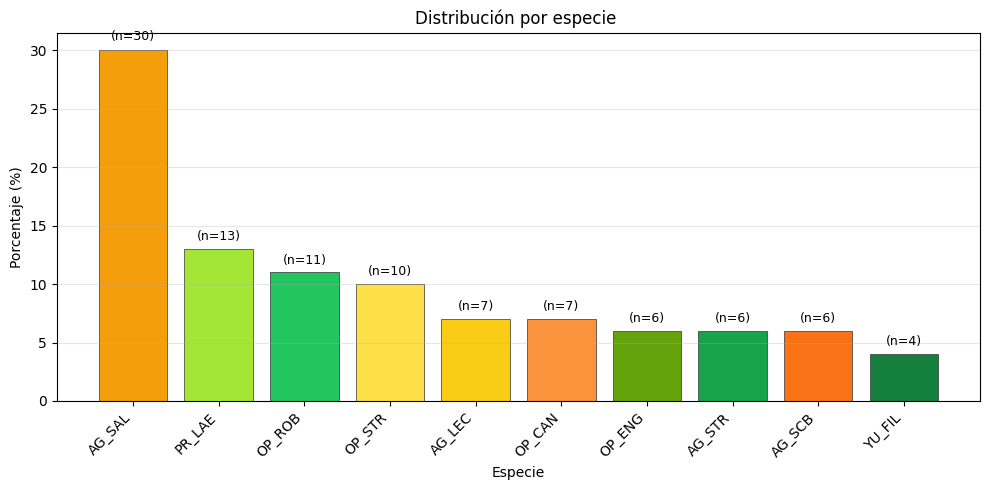

Guardados: composition_counts.csv y hist_porcentajes_especie.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


PALETTE = {
    "AG_SAL": "#F59E0B", "OP_ROB": "#22C55E", "OP_STR": "#FDE047",
    "OP_ENG": "#65A30D", "OP_CAN": "#FB923C", "PR_LAE": "#A3E635",
    "AG_LEC": "#FACC15", "AG_STR": "#16A34A", "AG_SCB": "#F97316",
    "YU_FIL": "#15803D",
}
DEFAULT_COLOR = "#999999"

df = pd.read_csv("assignments.csv")
df["status"] = df["status"].str.lower().str.strip()
df["species_id"] = df["species_id"].astype(str).str.strip()
plot_df = df[(df["status"] != "blocked") & (df["species_id"] != "")].copy()

counts = (plot_df.groupby("species_id", as_index=False)
          .size()
          .rename(columns={"size":"count"}))
total = counts["count"].sum()
counts["percent"] = (counts["count"] / total) * 100
counts = counts.sort_values("percent", ascending=False).reset_index(drop=True)

counts.to_csv("composition_counts.csv", index=False)

print(counts.to_string(index=False, float_format=lambda x: f"{x:0.2f}"))


colors = [PALETTE.get(sp, DEFAULT_COLOR) for sp in counts["species_id"]]

plt.figure(figsize=(10, 5))
bars = plt.bar(counts["species_id"], counts["percent"], color=colors, edgecolor="#333333", linewidth=0.5)

plt.ylabel("Porcentaje (%)")
plt.xlabel("Especie")
plt.title("Distribución por especie ")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)

for bar, cnt in zip(bars, counts["count"]):
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + max(0.5, 0.02*y),
             f"(n={cnt})",
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("hist_porcentajes_especie.png", dpi=200)
plt.show()

print("Guardados: composition_counts.csv y hist_porcentajes_especie.png")


species_id  expected_count  final_count  diff_count  expected_percent  final_percent  diff_percent  lower_percent  upper_percent  in_band
    AG_LEC            6.38            7        0.62              6.38            7.0          0.62           5.29           7.48     True
    AG_SAL           29.79           30        0.21             29.79           30.0          0.21          28.28          31.30     True
    AG_SCB            6.38            6       -0.38              6.38            6.0         -0.38           5.33           7.44     True
    AG_STR            6.38            6       -0.38              6.38            6.0         -0.38           5.29           7.47     True
    OP_CAN            7.45            7       -0.45              7.45            7.0         -0.45           6.38           8.52     True
    OP_ENG            5.78            6        0.22              5.78            6.0          0.22           4.79           6.76     True
    OP_ROB           11.09        

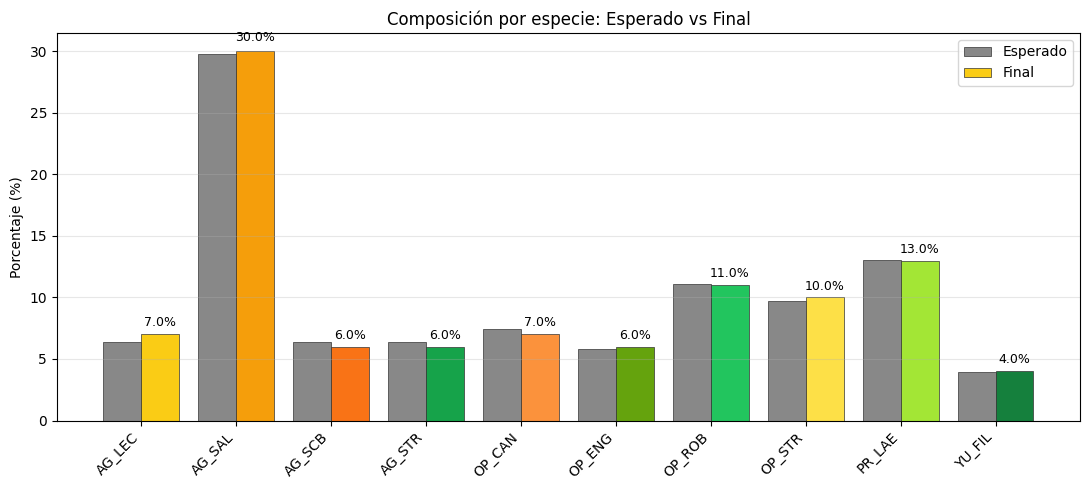

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

PALETTE = {
    "AG_SAL": "#F59E0B","OP_ROB": "#22C55E","OP_STR": "#FDE047","OP_ENG": "#65A30D",
    "OP_CAN": "#FB923C","PR_LAE": "#A3E635","AG_LEC": "#FACC15","AG_STR": "#16A34A",
    "AG_SCB": "#F97316","YU_FIL": "#15803D"
}
DEFAULT_COLOR = "#999999"

SPECIES_IDS = ["AG_LEC","AG_SAL","AG_SCB","AG_STR","OP_CAN","OP_ENG","OP_ROB","OP_STR","PR_LAE","YU_FIL"]

assign  = pd.read_csv("assignments.csv")
targets = pd.read_csv("species_targets.csv")  # species_id,f_target,v_tol

assign["status"] = assign["status"].str.lower().str.strip()
assign["species_id"] = assign["species_id"].astype(str).str.strip()
plot_df = assign[(assign["status"] != "blocked") & (assign["species_id"] != "")]
T = len(plot_df)


final_counts = (plot_df.groupby("species_id", as_index=False)
                .size().rename(columns={"size":"final_count"}))

df = (targets.copy()
      .assign(species_id=lambda d: d["species_id"].astype(str).str.strip())
      .set_index("species_id").reindex(SPECIES_IDS).reset_index())

df = df.merge(final_counts, on="species_id", how="left").fillna({"final_count":0})


df["expected_count"]   = df["f_target"] * T
df["expected_percent"] = df["f_target"] * 100
df["v_tol_percent"]    = df["v_tol"] * 100
df["lower_percent"]    = (df["f_target"] - df["v_tol"]) * 100
df["upper_percent"]    = (df["f_target"] + df["v_tol"]) * 100
df["final_percent"]    = (df["final_count"] / T) * 100
df["diff_count"]       = df["final_count"] - df["expected_count"]
df["diff_percent"]     = df["final_percent"] - df["expected_percent"]
df["in_band"]          = (df["final_percent"] >= df["lower_percent"]) & (df["final_percent"] <= df["upper_percent"])

cols_show = ["species_id","expected_count","final_count","diff_count",
             "expected_percent","final_percent","diff_percent","lower_percent","upper_percent","in_band"]
print(df[cols_show].round(2).to_string(index=False))
df.round(4).to_csv("composition_expected_vs_final.csv", index=False)
print("Guardado: composition_expected_vs_final.csv")

x = np.arange(len(df))
w = 0.4

fig, ax = plt.subplots(figsize=(11, 5))



ax.bar(x - w/2, df["expected_percent"], width=w, label="Esperado", color="#888888", edgecolor="#333333", linewidth=0.5)
colors = [PALETTE.get(sp, DEFAULT_COLOR) for sp in df["species_id"]]
bars = ax.bar(x + w/2, df["final_percent"], width=w, label="Final", color=colors, edgecolor="#333333", linewidth=0.5)

for bar, pct in zip(bars, df["final_percent"]):
    y = bar.get_height()
    ax.text(bar.get_x()+bar.get_width()/2, y + max(0.4, 0.02*y), f"{pct:.1f}%", ha="center", va="bottom", fontsize=9)

ax.set_xticks(x, df["species_id"], rotation=45, ha="right")
ax.set_ylabel("Porcentaje (%)")
ax.set_title("Composición por especie: Esperado vs Final")
ax.grid(axis="y", alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig("comparacion_esperado_vs_final.png", dpi=200)
plt.show()
